# Validating performance of classification models
This notebook takes you through the steps to train and evaluate a classification model using a confusion matrix and the F-Measure.

## The model
We're using the iris flower classification model from previous chapters. 
The model has 4 input neurons and 3 output neurons. We'll be using a softmax activation on the output layer to create a classification model.

In [2]:
from cntk import default_options, input_variable
from cntk.layers import Dense, Sequential
from cntk.ops import log_softmax, relu, sigmoid

model = Sequential([
    Dense(4, activation=relu),
    Dense(3, activation=log_softmax)
])

features = input_variable(4)
labels = input_variable(3)

z = model(features)

## Data preprocessing
We're going to use the original CSV file for the iris dataset.
It contains four columns with features. The final column is the label (the species of the sample).

The labels are stored as string and we need to have a binary encoded variant.
So we'll use a Binarizer from scikit-learn to encode the labels in the proper format.

In [3]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelBinarizer

df_source = pd.read_csv('iris.csv', 
    names=['sepal_length', 'sepal_width','petal_length','petal_width', 'species'], 
    index_col=False)

label_encoder = LabelBinarizer()

X = df_source.iloc[:, :4].values
y = df_source.iloc[:, -1:].values

y = label_encoder.fit_transform(y)

X = X.astype(np.float32)
y = y.astype(np.float32)

## Split the dataset into a training and test set
Before we start training, we'll split the dataset into a training and test set using the `train_test_split` function from scikit-learn. This gives us a small set of samples to later validate the model on.

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, stratify=y)

## Train the model
Now that we have a dataset, let's train the model with it.
For this we define a loss and a learner. We can then use the loss to train the model.

In [1]:
import cntk

@cntk.Function
def criterion_factory(output, target):
    loss = cntk.losses.cross_entropy_with_softmax(output, target)
    metric = cntk.losses.fmeasure(output, target, beta=1)
    
    return loss, metric

In [5]:
from cntk.losses import cross_entropy_with_softmax
from cntk.learners import sgd 
from cntk.logging import ProgressPrinter

progress_writer = ProgressPrinter(0)
loss = criterion_factory(z, labels)
learner = sgd(z.parameters, 0.1)

train_summary = loss.train((X_train,y_train), 
                           parameter_learners=[learner], 
                           callbacks=[progress_writer], 
                           minibatch_size=16, max_epochs=15)

 average      since    average      since      examples
    loss       last     metric       last              
 ------------------------------------------------------
Learning rate per minibatch: 0.1
     4.62       4.62      0.189      0.189            16
     2.12      0.864      0.279      0.324            48
      1.4      0.869      0.319      0.349           112
    0.877      0.877      0.418      0.418            16
    0.768      0.713      0.486       0.52            48
    0.769      0.771       0.47      0.459           112
    0.785      0.785      0.497      0.497            16
    0.702       0.66       0.56      0.592            48
    0.701      0.701      0.545      0.533           112
    0.703      0.703      0.564      0.564            16
    0.641       0.61      0.623      0.652            48
    0.641      0.641      0.606      0.594           112
    0.655      0.655      0.605      0.605            16
    0.607      0.583       0.66      0.688            48
 

## Validating the model
After the model is trained, we can start the validation process. We're going to perform two kinds of validation.
First, we'll look at a confusion matrix to understand how the model is doing on specific species of flowers. After that we'll also calculate the F-Measure.

### Using a confusion matrix
We can use the `confusion_matrix` function from scikit-learn to create a confusion matrix. This functions needs to know the real labels for our test samples and the predicted labels for the same test samples. Both of these sets of values need to be numeric.

The true labels and predicted labels are both binary encoded as is required by  our model. You can convert these binary representations into numeric values using the `argmax` function. We'll run it over all the samples to convert the one-hot vectors into their numeric version. 

We do the same for the predictions. We'll take the `argmax` function and pass in the output of the neural network. Notice, our neural network is a function so we can call it with the test set directly. The `y_pred` variable now contains the numeric value of the predicted classes.

Once we have the true labels and the predicted labels we can calculate a confusion matrix.

In [26]:
from sklearn.metrics import confusion_matrix

y_true = np.argmax(y_test, axis=1)
y_pred = np.argmax(z(X_test), axis=1)

matrix = confusion_matrix(y_true=y_true, y_pred=y_pred)

print(matrix)

[[10  0  0]
 [ 0  4  6]
 [ 0  0 10]]


We now have a bunch of numbers that don't look pretty or understandable. We need to visualize them to see what we're dealing with. The function below demonstrates how to visualize a confusion matrix using a heatmap from seaborn.

**Important** Make sure you have `seaborn` installed by running `pip install seaborn` in an anaconda prompt.

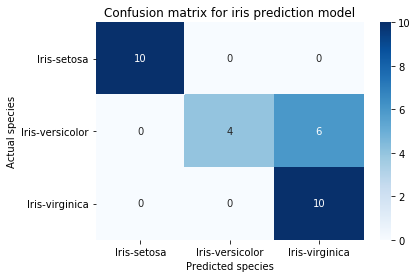

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

g = sns.heatmap(matrix, 
                annot=True, 
                xticklabels=label_encoder.classes_.tolist(), 
                yticklabels=label_encoder.classes_.tolist(), 
                cmap='Blues')

g.set_yticklabels(g.get_yticklabels(), rotation=0)

g.set_xlabel('Predicted species')
g.set_ylabel('Actual species')
g.set_title('Confusion matrix for iris prediction model')

plt.show()

### Using the F-Measure function
You will have noticed that the confusion matrix isn't too bad for this smaller model. But it's still nice to have a single performance number that we can use to compare models later on.

To calculate the F-Measure, you need to use the `fmeasure` function from the losses package in CNTK. To measure the performance using this function you need to invoke it with the right settings and then use the `test` method to calculate the output.

In [6]:
loss.test((X_test, y_test))

{'metric': 0.8220167795817057, 'samples': 30}